# CITS4401 Trading Bot

## Install Packages ccxt, ta if import fails

In [1]:
%pip install -q ccxt
%pip install -q ta

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Imports

In [97]:
import pandas as pd
import ccxt
import ta
import random
import matplotlib.pyplot as plt

# Trading Bot

In [119]:
RSI_OVERBOUGHT = 70
RSI_OVERSOLD = 30
class TradingBot:
    # Constructor for TradingBot
    def __init__(self, parameters, data):
        # P format = [window_slow, window_fast, window_sign]
        self.P = parameters
        # self.window_fast = parameters[0]
        # self.window_slow = parameters[1]
        # self.window_sign = parameters[2]
        self.data = data
        # Initialize any other necessary attributes
    
    # Buy trigger function
    def buy_trigger(self, t, P):
        return self.buy(t, P) and not self.buy(t-1, P) and not (self.sell(t, P) and not self.sell(t-1, P))

    # Sell trigger function
    def sell_trigger(self, t, P):
        return self.sell(t, P) and not self.sell(t-1, P) and not (self.buy(t, P) and not self.buy(t-1, P))

    # Buy function
    def buy(self, t, P):
        dnf = 1
        for i in range(len(P)):
            lit = 1
            if (P[i][0] == "macd"):
                a = self.macd_indicator(t,P[i])
                lit = a[0] > a[1] and a[2] < a[3]
            elif (P[i][0] == "bb"):
                pass
            elif (P[i][0] == "rsi"):
                a = self.rsi_indicator(t, P[i])
                lit = a.item() < RSI_OVERSOLD
            elif (P[i][0] == "obv"):
                pass
            
            if (i == 0): # for the first literal
                dnf = lit
            elif(P[i][1]==1): # it is an OR conditional
                dnf = dnf or lit 
            else: # it is an AND conditional
                dnf = dnf and lit
        return dnf
    
    # Sell function
    def sell(self, t, P):
        dnf = 1
        for i in range(len(P)):
            if (P[i][0] == "macd"):
                a = self.macd_indicator(t,P[i])
                lit = a[0] < a[1] and a[2] > a[3]
            elif (P[i][0] == "bb"):
                a = self.bb_indicator(t, P[i])
                pass
            elif (P[i][0] == "rsi"):
                a = self.rsi_indicator(t, P[i])
                lit = a.item() > RSI_OVERBOUGHT
            elif (P[i][0] == "obv"):
                pass

            if (i == 0): # for the first literal
                dnf = lit
            elif(P[i][1]): # it is an OR conditional
                dnf = dnf or lit 
            else:
                dnf = dnf and lit
        return dnf

    def macd_indicator(self, t, P):
        
        macd_line      = self.data["macd"].loc[t]
        signal_line    = self.data["macd_sig"].loc[t]

        if t-1 > 0:
            prev_macd   = self.data["macd"].loc[t-1]
            prev_signal = self.data["macd_sig"].loc[t-1]
        else:
            prev_macd   = self.data["macd"].loc[0] 
            prev_signal = self.data["macd_sig"].loc[0]
        
        return [macd_line, signal_line, prev_macd, prev_signal]


    def bb_indicator(self,t,P):
        # Define Bollinger Bands parameters
        window = int(P[2])
        window_dev = int(P[3])

        prices = self.data.loc[:t, 'close']
        bb_ind = ta.volatility.BollingerBands(close=prices,
                                              window=window,
                                              window_dev=window_dev)


    def rsi_indicator(self,t,P):

        # Get close prices for RSI
        if t-1 > 0:
            rsi_line  = self.data["rsi"].loc[t]
        else:
            rsi_line  = self.data["rsi"].loc[0]
        return rsi_line 

    def sma_indicator(self,t,P):
        pass

    # if need make for o,h,l,c,v data
    def candle_value(self,t):
        pass

    # Run the trading bot
    def run(self):
        # Initialise variables
        AUD = 100.0     # starting AUD holdings
        BTC = 0.0       # starting BTC holdings
        buy_triggered = False
        prices = self.data['close']
        for p in self.P:
            type = p[0]
            if type =="macd":
                macd_indicator = ta.trend.MACD(close=prices, window_slow=p[2], window_fast=p[3], window_sign=p[4])
                self.data["macd"] = macd_indicator.macd()
                self.data["macd_sig"] = macd_indicator.macd_signal()
            elif type == "rsi":
                rsi_indicator = ta.momentum.RSIIndicator(close = prices, window = p[2])
                self.data["rsi"] = rsi_indicator.rsi()
        
        aud_list = []
        btc_list = []
        t_list = []
        sell_date = []
        sell_price = []
        buy_date = []
        buy_price = []
        # Loop through each day in the data
        for t in range(len(self.data)):
            aud_list.append(AUD)
            btc_list.append(BTC)
            t_list.append(t)
            # print("aud {}".format(AUD))
            # print("btc {}".format(BTC))
            # Check if a buy trigger occurs and there is no concurrent sell trigger
            if self.buy_trigger(t, self.P) and not buy_triggered:
                buy_triggered = True
                BTC = AUD * 0.98 / self.data['close'][t]
                AUD = 0.0
                
                buy_date.append(t)
                buy_price.append(self.data['close'][t])
                
                # print("aud{}".format(AUD))
                # print("btc {}".format(BTC))
            # Check if a sell trigger occurs and there is no concurrent buy trigger
            elif self.sell_trigger(t, self.P) and buy_triggered:
                buy_triggered = False
                AUD = BTC * 0.98 * self.data['close'][t]
                BTC = 0.0
                
                sell_date.append(t)
                sell_price.append(self.data['close'][t])              
                
                # print("aud{}".format(AUD))
                # print("btc {}".format(BTC))
            # Sell remaining BTC at the end of the test period
            elif t == len(self.data)-1 and BTC > 0:
                AUD = BTC * 0.98 * self.data['close'][t]
                BTC = 0.0
        
        # aud_list.append(AUD)
        # btc_list.append(BTC)
        # t_list.append(t)
        return AUD, aud_list, btc_list, t_list, self.data['close'], sell_date, sell_price,  buy_date, buy_price, 

In [3]:
#from bot import TradingBot

class GeneticAlgorithm:
    
    # Constructor for GeneticAlgorithm
    def __init__(self, population_size, num_generations, mutation_rate, crossover_rate, data):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.num_generations = num_generations
        self.data = data
        
        # Define the range of parameter values for the MACD indicator
        self.PARAMETER_RANGES = {
            'window_slow': range(26, 50),
            'window_fast': range(12, 25),
            'window_sign': range(9, 15)
        }
        
    def run(self):
        # Generate an initial population of bots with different parameters
        population = []
        for n in range(self.population_size):
            # Gets random parameters within the ranges specified
            w_slow = random.choice(self.PARAMETER_RANGES['window_slow'])
            w_fast = random.choice(self.PARAMETER_RANGES['window_fast'])
            w_sign = random.choice(self.PARAMETER_RANGES['window_sign'])
            P = [w_slow, w_fast, w_sign]
            bot = TradingBot(P, self.data)  # Returns finalAUD
            botInstance = [bot.run(), P]
            population.append(botInstance) 

        # Run the genetic algorithm for number of generations
        for g in range(self.num_generations):
            # Evaluate fitness of the initial population
            fitness_scores = self.evaluate_fitness(population)
            
            # Select the top performing bots
            parents = self.select_parents(population, fitness_scores)
            
            # Create offspring through crossover and mutation
            offspring = self.reproduce(parents)
            
            # Replace the old population with the new one
            population = offspring
            
        # Evaluate the fitness of the final population
        fitness_scores = self.evaluate_fitness(population)
        
        # Return the best performing bot in the final population
        best_bot_index = fitness_scores.index(max(fitness_scores))
        best_bot = population[best_bot_index]
        return best_bot
    
    # Calculate fitness function
    def calculate_fitness(self, bot_final_AUD):
        profit = bot_final_AUD - 100.0
        return profit
        
    # Evaluate fitness of each bot in the population
    def evaluate_fitness(self, population):
        return [self.calculate_fitness(bot[0]) for bot in population]
       
    # Select parents of the next generation
    def select_parents(self, population, fitness_scores):
        elite_indices = sorted(range(len(fitness_scores)), key=lambda i: fitness_scores[i], reverse=True)[:self.population_size // 2]
        elite_bots = [population[i] for i in elite_indices]
        return elite_bots
    
    # Create offspring by applying through genetic operators crossover and mutation
    def reproduce(self, parents):
        offspring = parents.copy()
        while len(offspring) < self.population_size:
            parent1 = random.choice(parents)
            parent2 = random.choice(parents)
            child1, child2 = self.crossover(parent1, parent2)
            offspring.extend([self.mutation(child1), self.mutation(child2)])
        return offspring
    
    # Crossover function
    def crossover(self, parent1, parent2):
        child1 = parent1.copy()
        child2 = parent2.copy()
        if random.random() < self.crossover_rate:
            crossover_point = random.randint(1, len(parent1[1]) - 1)
            child1[1][:crossover_point] = parent2[1][:crossover_point]
            child2[1][:crossover_point] = parent1[1][:crossover_point]
        return (child1, child2)
    
    # Mutation function
    def mutation(self, bot):
        mutated_bot = bot.copy()
        for i in range(len(mutated_bot[1])):
            if random.random() < self.mutation_rate:
                if i == 0:
                    mutated_bot[1][i] = random.choice(self.PARAMETER_RANGES['window_slow'])
                elif i == 1:
                    mutated_bot[1][i] = random.choice(self.PARAMETER_RANGES['window_fast'])
                elif i == 2:
                    mutated_bot[1][i] = random.choice(self.PARAMETER_RANGES['window_sign'])
        return mutated_bot


In [4]:
#from ga import GeneticAlgorithm

# Retrieve OHLCV data
def getOHLCVdata():
    # Initialize the Kraken exchange
    kraken = ccxt.kraken()
    # Retrieve the historical data for BTC/AUD from the Kraken exchange
    ohlcv = kraken.fetch_ohlcv('BTC/AUD', '1d')
    # Convert the data to a pandas DataFrame
    data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    # Convert the timestamp to a datetime object
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    return data


In [5]:
POPULATION_SIZE = 10
NUM_GENERATIONS = 50
MUTATION_RATE   = 0.1
CROSSOVER_RATE  = 0.8
DATA = getOHLCVdata()

In [6]:
DATA;

In [7]:
ga = GeneticAlgorithm(POPULATION_SIZE, NUM_GENERATIONS, MUTATION_RATE, CROSSOVER_RATE, DATA)

In [8]:
print(ga.run())

26


TypeError: 'int' object is not subscriptable

In [120]:
bot = TradingBot([["macd", 0, 30, 20, 9]], DATA)

In [121]:
aud, aud_vals, btc_vals, time_vals, close_data, sell_date, sell_price,  buy_date, buy_price = bot.run()

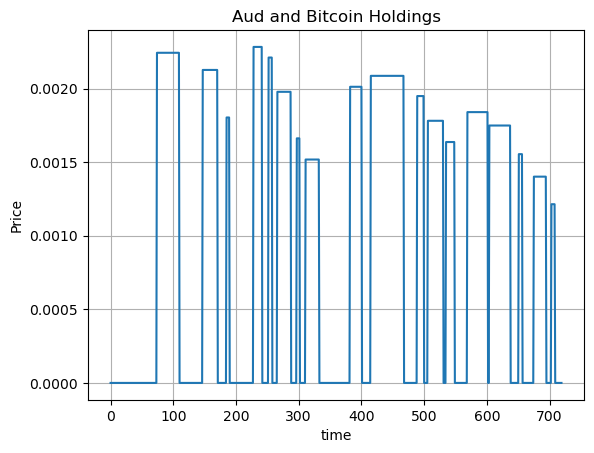

In [140]:
# Data for plotting

fig, ax = plt.subplots()
#ax.plot(time_vals, aud_vals)
ax.plot(time_vals, btc_vals)

ax.set(xlabel='time', ylabel='Price',
       title='Aud and Bitcoin Holdings')
ax.grid()

fig.savefig("test.png")
plt.show()

In [128]:
close_data;

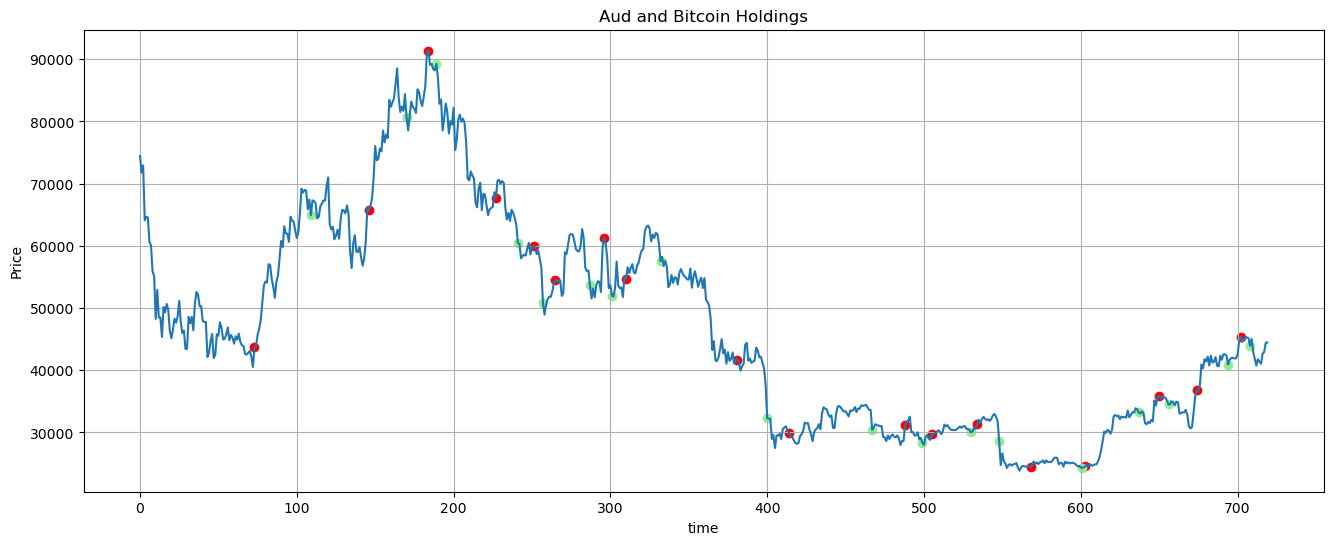

In [146]:
# Data for plotting

fig, ax = plt.subplots()
#ax.plot(time_vals, aud_vals)
ax.plot(time_vals, close_data)

ax.scatter(buy_date, buy_price, color="red")

ax.scatter(sell_date, sell_price, color="lightgreen")

ax.set(xlabel='time', ylabel='Price',
       title='Aud and Bitcoin Holdings')
ax.grid()

fig.set_figwidth(16)
fig.set_figheight(6)

plt.show()